In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 14

from sklearn import linear_model, model_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score, brier_score_loss

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
full_df = pd.read_csv('../../data/full_df.csv')
# train_df = pd.read_csv('../../data/train_df.csv')
# prior_df = pd.read_csv('../../data/prior_df.csv')
# test_df = pd.read_csv('../../data/test_df.csv')

In [3]:
full_df.drop('Unnamed: 0',axis=1,inplace=True)
full_df.head()

,user_id,product_id,eval_set,target,order_id,user_product_count,user_product_first_order,user_product_last_order,user_product_avg_basket_placement,product_ordered_vol,...,user_reorder_ratio,user_total_orders,user_lifetime_days,user_avg_days_between_orders,user_max_time_between_orders,user_min_time_between_orders,user_avg_cart_size,user_product_order_rate,user_product_reorder_rate,user_product_last_time_product_ordered
0,112108,49302,train,1,1,3,1,4,2.000,170,...,0.765,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
1,112108,11109,train,1,1,3,1,4,3.333,4579,...,0.765,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
2,112108,43633,train,1,1,3,1,4,4.000,663,...,0.765,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
3,112108,22035,train,1,1,3,1,4,6.000,61241,...,0.765,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
4,79431,19660,train,1,36,16,2,23,4.562,57921,...,0.500,23,3238.000,17.598,30.000,2.000,8.391,0.696,0.727,0


In [4]:
#filling in null values - for previous calculations where user didn't do any reorders
full_df.product_ordered_twice_vol.fillna(0,inplace=True)
full_df.product_order_twice_ratio.fillna(0,inplace=True)
full_df.user_unique_reorder_count.fillna(0,inplace=True)
full_df.user_unique_reorder_perc.fillna(0,inplace=True)
full_df.user_total_items_after_first_order.fillna(0,inplace=True)
full_df.user_reorder_ratio.fillna(0,inplace=True)
full_df.isnull().sum()

user_id                                   0
product_id                                0
eval_set                                  0
target                                    0
order_id                                  0
user_product_count                        0
user_product_first_order                  0
user_product_last_order                   0
user_product_avg_basket_placement         0
product_ordered_vol                       0
product_reordered_vol                     0
product_ordered_once_vol                  0
product_ordered_twice_vol                 0
product_order_twice_ratio                 0
product_avg_reorders                      0
product_overall_reorder_prob              0
user_total_products                       0
user_total_products_reordered             0
user_unique_product_count                 0
user_unique_reorder_count                 0
user_unique_product_perc                  0
user_unique_reorder_perc                  0
user_total_items_after_first_ord

In [5]:
print(full_df.target.value_counts())
print(full_df.target.value_counts(normalize=True))


0    7645837
1     828824
Name: target, dtype: int64
0   0.902
1   0.098
Name: target, dtype: float64


<AxesSubplot:>

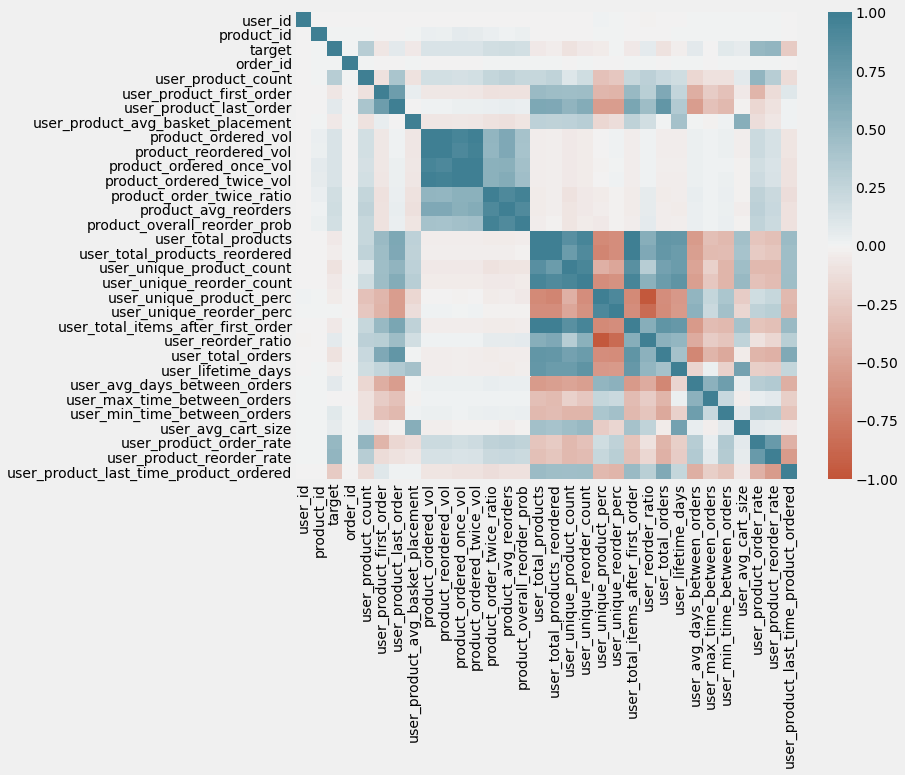

In [6]:
sns.heatmap(full_df.corr(),vmin=-1, vmax=1, center=0,
           cmap=sns.diverging_palette(20, 220, n=200))

### Multicolinearity Check 
columns that have high correlation with other features

In [7]:
cor_matrix = full_df.corr().abs()
upper = cor_matrix.where(
    np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
# print(upper)

drop_these = [column for column in upper.columns if any(upper[column] > 0.90)]

In [8]:
full_new = full_df.drop(full_df[drop_these], axis=1)
full_new.head()

,user_id,product_id,eval_set,target,order_id,user_product_count,user_product_first_order,user_product_last_order,user_product_avg_basket_placement,product_ordered_vol,...,user_unique_product_perc,user_total_orders,user_lifetime_days,user_avg_days_between_orders,user_max_time_between_orders,user_min_time_between_orders,user_avg_cart_size,user_product_order_rate,user_product_reorder_rate,user_product_last_time_product_ordered
0,112108,49302,train,1,1,3,1,4,2.000,170,...,0.480,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
1,112108,11109,train,1,1,3,1,4,3.333,4579,...,0.480,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
2,112108,43633,train,1,1,3,1,4,4.000,663,...,0.480,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
3,112108,22035,train,1,1,3,1,4,6.000,61241,...,0.480,4,167.000,9.824,15.000,7.000,6.250,0.750,0.750,0
4,79431,19660,train,1,36,16,2,23,4.562,57921,...,0.523,23,3238.000,17.598,30.000,2.000,8.391,0.696,0.727,0


## Splitting Data
Will first split dataset into train, test, validation sets and then do a T/T/S on training set for model tuning

In [9]:
full_df.shape

(8474661, 33)

In [10]:
full_new.shape

(8474661, 23)

In [11]:
np.random.seed(42)
train, validate, test = \
        np.split(full_new.sample(frac=1, random_state=42), 
                 [int(.8*len(full_new)), int(.9*len(full_new))])
#                  [int(.8*len(full_new))])                 

In [12]:
print(train.shape) #80%
print(test.shape) #10%
print(validate.shape)

(6779728, 23)
(847467, 23)
(847466, 23)


In [13]:
X= train.drop(["target",'eval_set'],axis=1)
y= train['target']

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Z_scaled = scaler.fit_transform(X)
# Z_train = scaler.fit_transform(X_train)
# Z_test = scaler.transform(X_test)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [16]:
print(y_test.shape)
print(X_test.shape)

(1355946,)
(1355946, 21)


In [29]:
Z_scaled

array([[ 1.66191615, -0.2032578 ,  1.24699547, ...,  2.22032844,
         1.93700084, -0.67714546],
       [-1.70244517,  0.98767455, -0.94014384, ..., -0.82226388,
        -0.35823839, -0.38165854],
       [-0.33082275,  1.12988907, -0.08356789, ..., -0.77560589,
        -1.00561356,  0.35705875],
       ...,
       [ 1.68816738,  1.37073284, -0.61435728, ...,  1.0406793 ,
         0.6422505 , -0.67714546],
       [-1.6262813 , -1.46589495,  0.18450357, ..., -0.47601246,
        -0.79542682,  0.20931529],
       [-0.95777471,  1.60672598,  0.72462527, ..., -0.62580917,
        -0.69296078, -0.67714546]])

## Logistic Regression 

In [17]:
1-y_train.mean()

0.9020504511427635

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
X_train, X_test, y_train, y_test = train_test_split(Z_scaled,y, test_size=0.2, random_state=42)

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print(logreg.score(X_test, y_test))

0.9965057605538864


In [20]:
reorder_logit_prob = logreg.predict_proba(X_test)[:,1]

In [21]:
# reorder_logit_prob[reorder_logit_prob >=0.74]

Goal is to set probability threshold to different intervals, and see which threshold produces the 'best' success metric. It looks like calculated probabilities with this model cap out at 74%

In [22]:
type(y_pred)

numpy.ndarray

### Tuning right probability threshold 

In [23]:
# accuracy=[]
# sensitivity=[]
# precision=[]
# recall=[]
# ppv=[]

for i in np.arange(0.0,0.8,0.05):
    prob_thresh = i
    cm = pd.DataFrame(metrics.confusion_matrix
                      (y_true=y_test, y_pred=reorder_logit_prob > i), 
                      columns=['Negative Pred', 'Positive Pred'])
    tn = cm.iloc[0,0]
    fn = cm.iloc[1,0]
    fp = cm.iloc[0,1]
    tp = cm.iloc[1,1]
    
    acc = (tp+tn) / (tp+tn+fp+fn)
    sen = (tp) / (tp+fn) #summarizes how well the positive class was predicted.
    prec = tp / (tp+fp) #summarizes the fraction of examples assigned the positive class that belong to the positive class
    rec = tp/(tp+fn) #same as sensitivity 
    pp = tp / (tp+fp)
    
#     accuracy.append(acc)
#     sensitivity.append(sen)
#     precision.append(prec)
#     recall.append(rec)
#     ppv.append(pp)
#     print(i,'y_test:',y_test,'y_pred:',y_pred)

    f1=f1_score(y_test,reorder_logit_prob > i)
    brier=brier_score_loss(y_test, reorder_logit_prob > i)
    auc=roc_auc_score(y_test, reorder_logit_prob > i)

    print(round(i,2),f"accuracy:{acc:.5f},sensitivity:{sen:.5f},precision:{prec:.5f},recall:{rec:.5f}, ppv:{pp:5f}")
    print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")
    print(" ")

0.0 accuracy:0.10646,sensitivity:1.00000,precision:0.09835,recall:1.00000, ppv:0.098349
f1:0.17908,auc:0.50498,loss_score:0.89354
 
0.05 accuracy:0.99405,sensitivity:1.00000,precision:0.94250,recall:1.00000, ppv:0.942504
f1:0.97040,auc:0.99671,loss_score:0.00595
 
0.1 accuracy:0.99434,sensitivity:1.00000,precision:0.94512,recall:1.00000, ppv:0.945119
f1:0.97179,auc:0.99686,loss_score:0.00566
 
0.15 accuracy:0.99476,sensitivity:0.99998,precision:0.94900,recall:0.99998, ppv:0.949000
f1:0.97383,auc:0.99709,loss_score:0.00524
 
0.2 accuracy:0.99515,sensitivity:0.99992,precision:0.95271,recall:0.99992, ppv:0.952706
f1:0.97574,auc:0.99728,loss_score:0.00485
 
0.25 accuracy:0.99556,sensitivity:0.99976,precision:0.95660,recall:0.99976, ppv:0.956595
f1:0.97770,auc:0.99743,loss_score:0.00444
 
0.3 accuracy:0.99587,sensitivity:0.99949,precision:0.95983,recall:0.99949, ppv:0.959831
f1:0.97926,auc:0.99749,loss_score:0.00413
 
0.35 accuracy:0.99611,sensitivity:0.99901,precision:0.96250,recall:0.9990

In [24]:
print(classification_report(y_test, y_pred))
print(f1_score(y_test,y_pred))
print(brier_score_loss(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1223790
           1       0.97      1.00      0.98    132156

    accuracy                           1.00   1355946
   macro avg       0.98      1.00      0.99   1355946
weighted avg       1.00      1.00      1.00   1355946

0.9823165406406055
0.0034942394461136357
0.9961810492752543


In [25]:
cm = pd.DataFrame(metrics.confusion_matrix
                  (y_true=y_test, y_pred=reorder_logit_prob > 0.65), 
                  columns=['Negative Pred', 'Positive Pred'])
tn = cm.iloc[0,0]
fn = cm.iloc[1,0]
fp = cm.iloc[0,1]
tp = cm.iloc[1,1]

acc = (tp+tn) / (tp+tn+fp+fn)
sen = (tp) / (tp+fn)
prec = tp / (tp+fp)
rec = tp/(tp+fn)
pp = tp / (tp+fp)

f1=f1_score(y_test,reorder_logit_prob > .65)
brier=brier_score_loss(y_test, reorder_logit_prob > .65)
auc=roc_auc_score(y_test, reorder_logit_prob > .65)

print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")


f1:0.98060,auc:0.99210,loss_score:0.00381


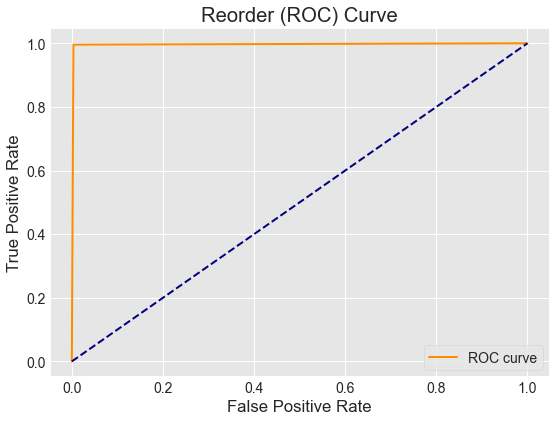

In [26]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

#Visualization for ROC curve
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(8,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reorder (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Feature Selection 

## Select K Best 

In [30]:
from sklearn.feature_selection import SelectKBest, chi2

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_model_new = SelectKBest(score_func=chi2,k=20)
fit= X_model_new.fit(X_train,y_train)
X_model_new
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Feature_Name','Score']  

In [31]:
feature_ranks = feature_scores.sort_values('Score', ascending=False).reset_index(drop=True)
feature_ranks.rename(columns={"Feature_Name":"Select_K_rank","Score":"Select_K_score"},inplace=True)
feature_ranks

,Select_K_rank,Select_K_score
0,product_ordered_vol,12675287207.302
1,order_id,7662175.736
2,user_product_last_time_product_ordered,5987623.229
3,user_lifetime_days,5060944.788
4,user_total_products,5044005.916
5,user_product_count,2985492.648
6,user_unique_product_count,2804633.172
7,user_total_orders,865448.485
8,user_product_last_order,565448.667
9,user_product_first_order,553381.755


<AxesSubplot:>

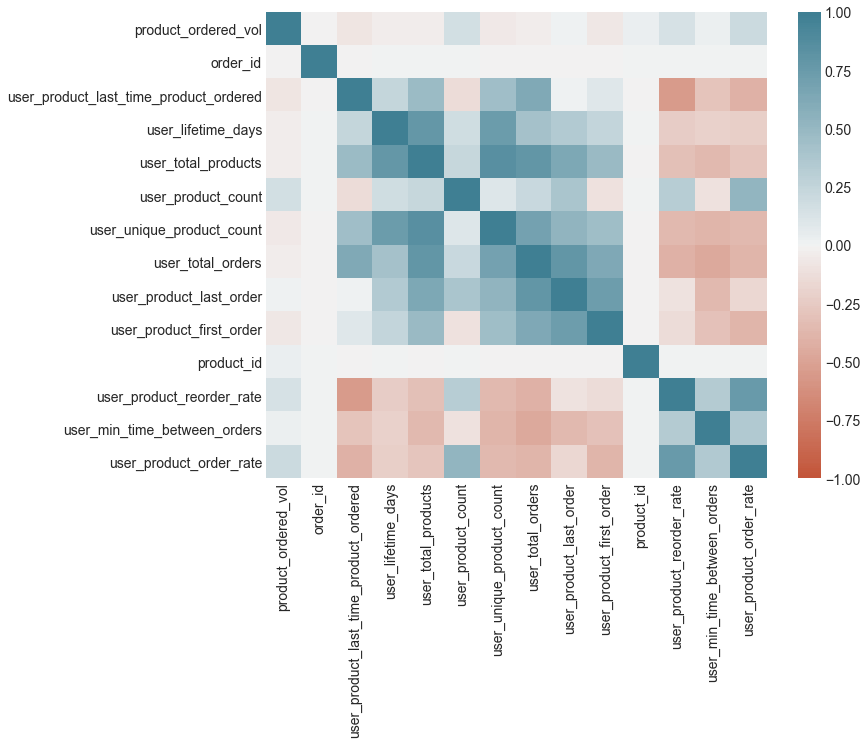

In [41]:
sns.heatmap(full_new[best_features].corr(),vmin=-1, vmax=1, center=0,
           cmap=sns.diverging_palette(20, 220, n=200))

In [32]:
best_features = feature_ranks['Select_K_rank'][:14]
best_features = best_features.tolist()

f1:0.98260,auc:0.99411,loss_score:0.00342


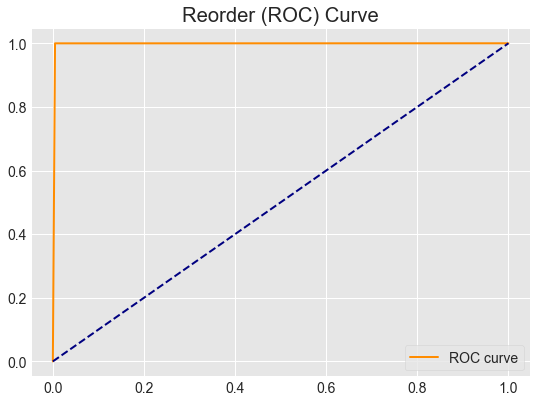

In [35]:
#New X and y with new features
X = train[best_features]
y = train['target']

#Standard Scalar
scaler = StandardScaler()
Z_scaled = scaler.fit_transform(X)

#TTS
X_train, X_test, y_train, y_test = train_test_split(
    Z_scaled,y, test_size=0.2, random_state=42)

#Fit model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

#store outputs 
y_pred = logreg.predict(X_test)

#store probabilities 
reorder_logit_prob = logreg.predict_proba(X_test)[:,1]

#create confusion matrix and metrics 
cm = pd.DataFrame(metrics.confusion_matrix
                  (y_true=y_test, y_pred=reorder_logit_prob > 0.65), 
                  columns=['Negative Pred', 'Positive Pred'])
tn = cm.iloc[0,0]
fn = cm.iloc[1,0]
fp = cm.iloc[0,1]
tp = cm.iloc[1,1]

acc = (tp+tn) / (tp+tn+fp+fn)
sen = (tp) / (tp+fn)
prec = tp / (tp+fp)
rec = tp/(tp+fn)
pp = tp / (tp+fp)

f1=f1_score(y_test,reorder_logit_prob > .65)
brier=brier_score_loss(y_test, reorder_logit_prob > .65)
auc=roc_auc_score(y_test, reorder_logit_prob > .65)

print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

#plot ROC 
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

#Visualization for ROC curve
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(8,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.title('Reorder (ROC) Curve')
plt.legend(loc="lower right")
plt.show();

## RFE

In [ ]:
# from sklearn.feature_selection import RFE

# selector = RFE(logreg, n_features_to_select = 1)
# selector = selector.fit(X_train, y_train);

# order = selector.ranking_
# order

In [ ]:
# feature_rank = []
# for i in order:
#     feature_ranks.append(f"{i} {full_new.columns[i]}") 

## Select from model

In [ ]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(logreg, threshold= -np.inf, max_features =20)
sfm.fit(X_train, y_train)

# select_scores = pd.DataFrame(smf.estimator_.coef_)
# select_cols = pd.DataFrame(X_train.columns)

# feature_scores = pd.concat([select_cols, select_scores],axis=1)
# feature_scores.columns = ['select_from_model_cols','select_from_model_scores']

# feature_scores

feature_idx = sfm.get_support()
feature_name = X_train.columns[feature_idx]
feature_name


In [ ]:
new_cols = feature_name
X_new = df_removed[new_cols]
y_new = df_removed['target']

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_new, y_new)

reorder_logit_prob_new = logreg.predict_proba(X_test)[:,1]
reorder_thresh = reorder_logit_prob_new > 0.4

cm = pd.DataFrame(metrics.confusion_matrix
                  (y_true=y_new, y_pred=reorder_thresh), 
                  columns=['Negative Pred', 'Positive Pred'])
tn = cm.iloc[0,0]
fn = cm.iloc[1,0]
fp = cm.iloc[0,1]
tp = cm.iloc[1,1]

acc = (tp+tn) / (tp+tn+fp+fn)
sen = (tp) / (tp+fn)
prec = tp / (tp+fp)
rec = tp/(tp+fn)
pp = tp / (tp+fp)

f1=f1_score(y_test,reorder_thresh)
brier=brier_score_loss(y_test, reorder_thresh)
auc=roc_auc_score(y_test, reorder_thresh)

print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

## Validate
Run model against validation set

f1:0.22508222453342136,auc:0.6060184954263289


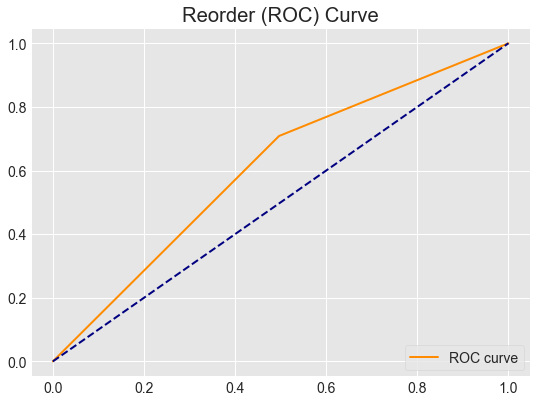

In [37]:
#New X and y for validation data
X_val= validate[best_features]
y_val= validate['target']

reorder_logit_prob = logreg.predict_proba(X_val)[:,1]

f1=f1_score(y_val,reorder_logit_prob > .65)
brier=brier_score_loss(y_val, reorder_logit_prob > .65)
auc=roc_auc_score(y_val, reorder_logit_prob > .65)

print(f"f1:{f1},auc:{auc}")

#plot ROC 
fpr, tpr, thresholds = roc_curve(y_val, reorder_logit_prob > .65)

#Visualization for ROC curve
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(8,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.title('Reorder (ROC) Curve')
plt.legend(loc="lower right")
plt.show();